## MINST

In [1]:
from sklearn.datasets import fetch_openml

minst = fetch_openml('mnist_784', as_frame=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X, y = minst.data, minst.target

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
28**2 == X.shape[1] # 784

True

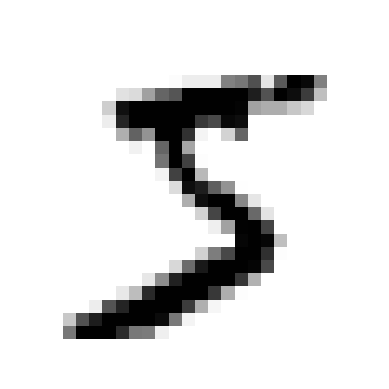

In [5]:
import matplotlib.pyplot as plt

def plot_digit(data) -> None:
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.show()

plot_digit(X[0])

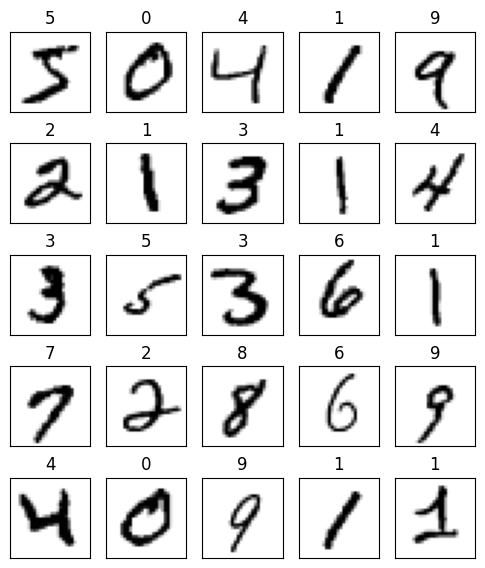

In [6]:
def plot_digits(weight: int, height: int) -> None:
    if weight == 1 and height == 1:
        plot_digit(X[0])
        return
    fig, axes = plt.subplots(weight, height, figsize=(weight+1, height+2))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(X[i].reshape(28, 28), cmap="binary")
        ax.yaxis.set_visible(False)
        ax.xaxis.set_visible(False)
        ax.set_title(y[i])
    plt.show()

plot_digits(5, 5)

In [7]:
y[0]

'5'

In [8]:
# Splitting the dataset (already shuffled)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [9]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([X[0]])

array([ True])

## Performance Measures

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# Dummy classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5) # always guess not 5
print(any(dummy_clf.predict(X_train))) # no 5s detected

False


In [13]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy") # 90% accuracy because 10% of the data is 5s

# Accuracy is not a good metric for classifiers

array([0.90965, 0.90965, 0.90965])

## Cross-Validation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


## Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
# Pretend we have a perfect classifier
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # TP / (TP + FP) # correct 83% of the time

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred) # TP / (TP + FN) # detects 65% of 5s

0.6511713705958311

In [20]:
# F1 score is the harmonic mean of precision and recall

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [21]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

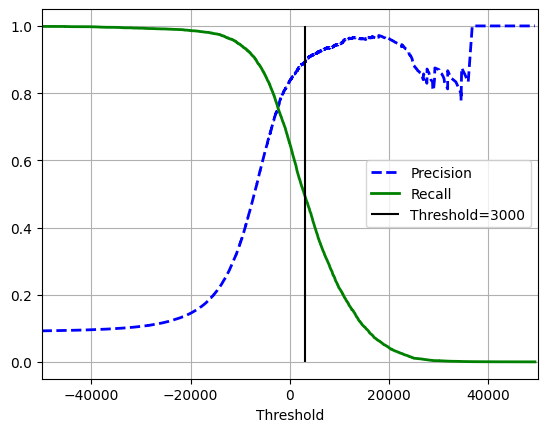

In [22]:
threshold = 3000
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", lw=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", lw=2)
plt.vlines(threshold, 0, 1.0, colors="k", label=f"Threshold={threshold}")
plt.xlim([-50000, 50000])
plt.xlabel("Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
idx_for_90_precision = (precisions >= 0.90).argmax() # first index where precision is >= 0.90

In [28]:
threshold_90_precision = thresholds[idx_for_90_precision]
threshold_90_precision

3370.0194991439566

In [31]:
recall_at_90_precision = recalls[idx_for_90_precision]
recall_at_90_precision

0.4799852425751706

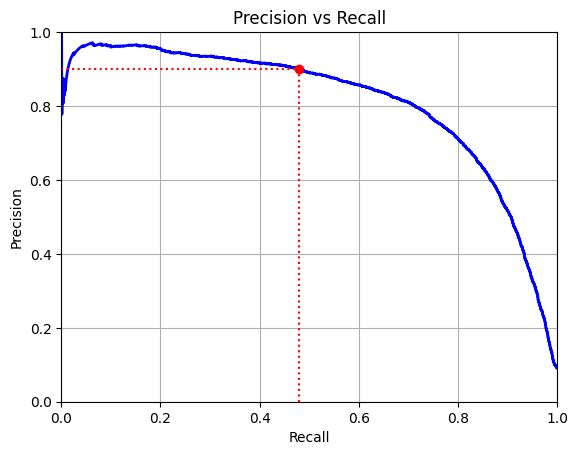

In [65]:
plt.plot(recalls, precisions, "b-", lw=2)
plt.plot([recall_at_90_precision, recall_at_90_precision], [0, 0.9], "r:")
plt.plot([0, recall_at_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_at_90_precision], [0.9], "ro")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

## ROC Curve

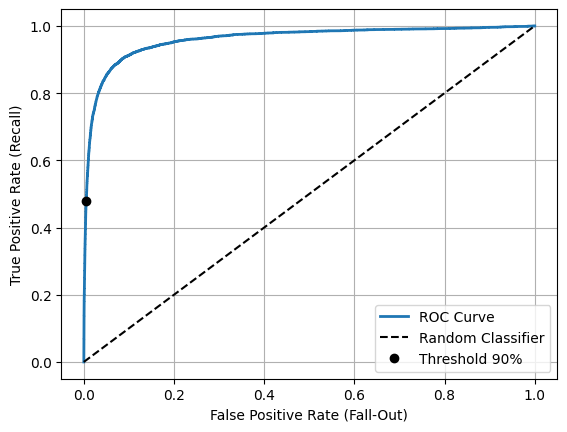

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_90], fpr[idx_for_threshold_90]

def plot_roc_curve(fpr, tpr) -> None:
    plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
    plt.plot([fpr_90], [tpr_90], "ko", label="Threshold 90%")
    plt.xlabel("False Positive Rate (Fall-Out)")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc="lower right")
    plt.grid(True)

plot_roc_curve(fpr, tpr)

In [60]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Random Forest Classifier